# Prepare the environment

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

## Global variables

## Load files

###  GTF file

Подгрузим gtf-файл. Для этого нам будет необходимо распарсить последний столбец

In [3]:
def parse_info(column):
    column = column.replace('"', '').split('; ')
    column_dict = dict(map(lambda x: x.split(' ')[:2], column))
    column_list_filt = [column_dict.get(key, 'NaN') for key in ['gene_id', 'exon_number', 'gene_name', 'exon_id']]
    return column_list_filt

In [4]:
gtf = pd.read_csv('../references/genome.gtf', sep='\t', header=None, skiprows=5, dtype='str', usecols=[0, 2, 3, 4, 8])
gtf.columns = ['chr_ind', 'type', 'chrstart', 'chrend', 'Info']
gtf = gtf[gtf.type == 'exon'].copy()
gtf[['gene_id', 'exon_number', 'gene_name', 'exon_id']] = gtf.Info.map(parse_info).to_list()
gtf.head()

,chr_ind,type,chrstart,chrend,Info,gene_id,exon_number,gene_name,exon_id
2,1,exon,108344807,108347562,"gene_id ""ENSMUSG00000104478""; gene_version ""2""...",ENSMUSG00000104478,1,Gm38212,ENSMUSE00001337335
5,1,exon,6980784,6981446,"gene_id ""ENSMUSG00000104385""; gene_version ""2""...",ENSMUSG00000104385,1,Gm7449,ENSMUSE00001339893
8,1,exon,108540067,108540244,"gene_id ""ENSMUSG00000101231""; gene_version ""2""...",ENSMUSG00000101231,1,Gm28283,ENSMUSE00001325295
11,1,exon,6986783,6987219,"gene_id ""ENSMUSG00000102135""; gene_version ""2""...",ENSMUSG00000102135,1,Gm37108,ENSMUSE00001339810
12,1,exon,6993624,6993812,"gene_id ""ENSMUSG00000102135""; gene_version ""2""...",ENSMUSG00000102135,2,Gm37108,ENSMUSE00001343179


### Biomart annotation

In [14]:
biomart_annotation = pd.read_csv('../references/biomart_export.txt', index_col=0, sep='\t')
biomart_annotation.head()

,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Gene start (bp),Gene end (bp),Gene name,Strand,Gene type,NCBI gene (formerly Entrezgene) ID,RefSeq mRNA ID
Gene stable ID,,,,,,,,,,
ENSMUSG00000064336,ENSMUSG00000064336.1,ENSMUST00000082387,ENSMUST00000082387.1,1,68,mt-Tf,1,Mt_tRNA,NaN,NaN
ENSMUSG00000064337,ENSMUSG00000064337.1,ENSMUST00000082388,ENSMUST00000082388.1,70,1024,mt-Rnr1,1,Mt_rRNA,NaN,NaN
ENSMUSG00000064338,ENSMUSG00000064338.1,ENSMUST00000082389,ENSMUST00000082389.1,1025,1093,mt-Tv,1,Mt_tRNA,NaN,NaN
ENSMUSG00000064339,ENSMUSG00000064339.1,ENSMUST00000082390,ENSMUST00000082390.1,1094,2675,mt-Rnr2,1,Mt_rRNA,NaN,NaN
ENSMUSG00000064340,ENSMUSG00000064340.1,ENSMUST00000082391,ENSMUST00000082391.1,2676,2750,mt-Tl1,1,Mt_tRNA,NaN,NaN


Отберём `protein_coding` гены

In [22]:
pc_genes = biomart_annotation[biomart_annotation['Gene type'] == 'protein_coding'].index.unique()
pc_genes.size

21691

### Counts

In [5]:
file_list = []
columns = []
for file in glob.glob('../countsHtseq/*'):
    sample_name = file.split('/')[-1].split('_')[0]
    df = pd.read_csv(file, sep='\t', index_col=0, header=None)
    file_list.append(df)
    columns.append(sample_name)

counts = pd.concat(file_list, axis=1)
counts.columns = columns
counts.index.name = 'gene_id'
counts.head()

,SRR3414631,SRR3414630,SRR3414636,SRR3414637,SRR3414635,SRR3414629
gene_id,,,,,,
ENSMUSG00000000001,5757,3963,3532,4078,3466,4507
ENSMUSG00000000003,0,0,0,0,0,0
ENSMUSG00000000028,472,275,137,152,152,348
ENSMUSG00000000031,65189,33334,48392,56187,55720,64723
ENSMUSG00000000037,90,71,45,54,43,81


# RPKM

Посчитаем длину экзонов для каждого гена

In [7]:
gtf['length'] = gtf['chrend'].astype(int) - gtf['chrstart'].astype(int)
gene_length = gtf[['length', 'gene_id']].groupby('gene_id').sum()
gene_length.head()

,length
gene_id,
ENSMUSG00000000001,3253
ENSMUSG00000000003,1586
ENSMUSG00000000028,6162
ENSMUSG00000000031,32498
ENSMUSG00000000037,26065


Вычислим RPKM:
$$
RPKM_i = \frac{count_i / length_i}{\sum_jcount_j} * 10^9
$$

In [8]:
# функция для подсчёта rpkm
def rpkm_calc(sample_counts):
    return sample_counts / (gene_length.length.values * sample_counts.sum()) * 1e9

In [27]:
# возьмём только protein-coding гены
counts = counts.loc[pc_genes]
gene_length = gene_length.loc[pc_genes]
rpkm_norm = counts.apply(rpkm_calc)
rpkm_norm.head()

,SRR3414631,SRR3414630,SRR3414636,SRR3414637,SRR3414635,SRR3414629
Gene stable ID,,,,,,
ENSMUSG00000064341,3270.305713,4009.491149,3417.475738,4247.303617,3379.566314,3004.020693
ENSMUSG00000064345,2302.414210,2742.763543,1921.105790,2147.399246,1891.383129,2024.405729
ENSMUSG00000064351,4023.806393,4323.775414,3179.331190,3620.564564,3138.934673,3520.241354
ENSMUSG00000064354,3.611321,4.645255,2.062283,3.666434,3.268546,2.396184
ENSMUSG00000064356,0.810027,0.434142,0.946175,0.000000,1.221903,1.550392


Сохраним все файлы

In [28]:
rpkm_norm.to_csv('../results/rpkm.csv')
counts.to_csv('../results/counts.csv')
gene_length.to_csv('../results/gene_length.csv')

Заменим названия генов для удобства

In [29]:
# create mapping dict
id_to_name = gtf[['gene_id', 'gene_name']].set_index('gene_id').gene_name.dropna().to_dict()

# replace id to names
rpkm_norm.index = rpkm_norm.index.map(lambda x: id_to_name.get(x, x))
rpkm_norm.head()

,SRR3414631,SRR3414630,SRR3414636,SRR3414637,SRR3414635,SRR3414629
Gene stable ID,,,,,,
mt-Nd1,3270.305713,4009.491149,3417.475738,4247.303617,3379.566314,3004.020693
mt-Nd2,2302.414210,2742.763543,1921.105790,2147.399246,1891.383129,2024.405729
mt-Co1,4023.806393,4323.775414,3179.331190,3620.564564,3138.934673,3520.241354
mt-Co2,3.611321,4.645255,2.062283,3.666434,3.268546,2.396184
mt-Atp8,0.810027,0.434142,0.946175,0.000000,1.221903,1.550392


Посмотрим на ген **Wnt4**

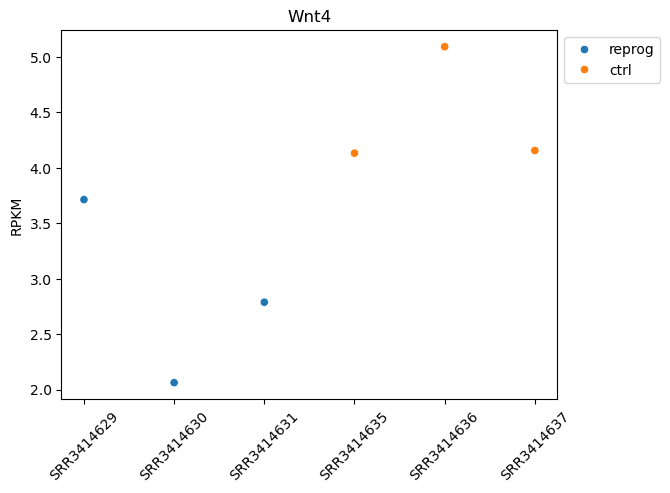

In [30]:
plot_df = rpkm_norm.loc['Wnt4'].sort_index().to_frame().reset_index()
plot_df['condition'] = ['reprog', 'reprog', 'reprog', 'ctrl', 'ctrl', 'ctrl']
ax = sns.scatterplot(plot_df, x='index', y='Wnt4', hue='condition')
ax.legend(fontsize=10, loc="upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel('')
ax.set_ylabel('RPKM')
ax.set_title('Wnt4')
plt.xticks(rotation=45);